# Monte Carlo Dropout (MCD) Quantification

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

The aim of this file is it to analyse the MCD uncertainty and identify correlations to other metrics. Furhtermore, the computational efficiency of MCD simulations should be analyzed and the minimal number of needed MCD simulations for a robust uncertainty estimation quantified.

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

### Import

In [50]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm
from scipy import stats
from scipy.stats import gamma, johnsonsu

import torch

from Settings import Directory, Plotting_Parameters
import DataReader
import DNN

import warnings
warnings.filterwarnings('ignore')

### Directory

In [5]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Full_V3"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [13]:
# Disable if figures should not be saved
plot_params.save_figures = True

### Load Data

In [3]:
datareader = DataReader()
df_full = datareader.load("Knee_Connection_Output_red.csv")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Extended_Database_filtered_converted.csv
extended_profiles_iterV2_1.csv
extended_profiles_iter_1.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


### Load Model

In [4]:
model = DNN()
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

print(model.data['data_reduction_factor'])

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features
0


## Evaluate Model

In [6]:
y_pred, test_loss = model.evaluate()
y_true = model.y_test.numpy()
model.get_metrics(y_pred.numpy())

{'MSE': 3.0903888e-05,
 'RMSE': 0.0055591264,
 'MAE': 0.0037376885,
 'R2': 0.9979280408006161,
 'MCDMS': 0.005261143387924681,
 'MCDUS': 0.057724938294168596}

Get uncertainty of full data set. 

⚠️Attention⚠️: The returned `mcd_std_unbiased` is unbiased (N-1). When calculating the standard deviation with `np.std(data,axis=0)` the default is a biased (N) calculation. Since the actual absolute values does not matter, but only the relative value, it does not matter which one is considered, but it should be consistent.

In [7]:
mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(num_samples=2000, dropout_prob=0.1)

$$\sigma_{\text{MC}}=\frac{\sigma}{\mu}$$

In [8]:
uncertainty = mcd_std_unbiased / mcd_mean

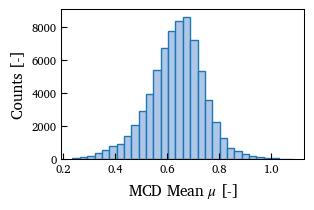

In [16]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(1/2))

_ = plt.hist(mcd_mean, 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
plt.xlabel(r'MCD Mean $\mu$ [-]')
plt.ylabel('Counts [-]')

if plot_params.save_figures:
     plt.savefig(rf'Plots\MC_Mean.svg', format='svg')

plt.show()

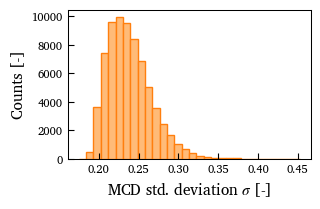

In [17]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(1/2))

_ = plt.hist(mcd_std_unbiased, 
             bins=30, 
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])
plt.xlabel('MCD std. deviation $\sigma$ [-]')
plt.ylabel('Counts [-]')

if plot_params.save_figures:
     plt.savefig(rf'Plots\MC_Std.svg', format='svg')

plt.show()

### Estimate Distribution Families

In [18]:
def fit_and_select_distribution(data, distributions):
    results = []
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            log_likelihood = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * log_likelihood
            results.append((dist_name, aic))
        except Exception:
            continue
    
    results.sort(key=lambda x: x[1])
    return results


In [19]:
def fit_and_select_distribution(data, distributions):
    best_fits = []
    n = len(data)
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(data)
            log_likelihood = np.sum(dist.logpdf(data, *params))
            k = len(params)
            aic = 2 * k - 2 * log_likelihood
            bic = k * np.log(n) - 2 * log_likelihood
            best_fits.append((dist_name, aic, bic))
        except Exception:
            continue
    best_fits.sort(key=lambda x: (x[1], x[2]))
    return best_fits

In [20]:
candidate_distributions = [
    'gamma', 'skewnorm', 'lognorm', 'weibull_min', 'beta',
    'gumbel_r', 'pareto', 'nakagami', 'expon', 'johnsonsu', 
    'triang', 'genextreme', 'norm'
]

mcd_mean_best_fits = fit_and_select_distribution(mcd_mean, candidate_distributions)
mcd_std_best_fits = fit_and_select_distribution(mcd_std_unbiased, candidate_distributions)
uncertainty_best_fits = fit_and_select_distribution(uncertainty, candidate_distributions)

print("Best fit distributions for MCD Mean:")
for dist_name, aic, bic in mcd_mean_best_fits:
    print(f"{dist_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")

print("\nBest fit distributions for MCD Std:")
for dist_name, aic, bic in mcd_std_best_fits:
    print(f"{dist_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")

print("\nBest fit distributions for Uncertainty:")
for dist_name, aic, bic in uncertainty_best_fits:
    print(f"{dist_name}: AIC = {aic:.2f}, BIC = {bic:.2f}")

Best fit distributions for MCD Mean:
johnsonsu: AIC = -122988.63, BIC = -122951.92
skewnorm: AIC = -122418.52, BIC = -122390.99
beta: AIC = -122099.67, BIC = -122062.96
weibull_min: AIC = -121547.69, BIC = -121520.16
norm: AIC = -121364.03, BIC = -121345.67
lognorm: AIC = -121254.72, BIC = -121227.19
nakagami: AIC = -121214.50, BIC = -121186.97
gamma: AIC = -119739.99, BIC = -119712.46
gumbel_r: AIC = -101953.59, BIC = -101935.24
triang: AIC = -77514.51, BIC = -77486.98
expon: AIC = 11244.81, BIC = 11263.16
pareto: AIC = 11282.58, BIC = 11310.11
genextreme: AIC = 39667.99, BIC = 39695.52

Best fit distributions for MCD Std:
lognorm: AIC = -320310.49, BIC = -320282.96
johnsonsu: AIC = -320292.25, BIC = -320255.55
gamma: AIC = -320196.16, BIC = -320168.63
skewnorm: AIC = -320190.31, BIC = -320162.78
gumbel_r: AIC = -319998.91, BIC = -319980.56
genextreme: AIC = -319998.65, BIC = -319971.12
nakagami: AIC = -317535.34, BIC = -317507.81
weibull_min: AIC = -315244.61, BIC = -315217.08
beta: 

In [21]:
dist_names_map = {
    'gamma': 'Gamma',
    'skewnorm': 'Skew-Normal',
    'lognorm': 'Log-Normal',
    'weibull_min': 'Weibull (Min)',
    'beta': 'Beta',
    'gumbel_r': 'Gumbel (Right)',
    'pareto': 'Pareto',
    'nakagami': 'Nakagami',
    'expon': 'Exponential',
    'johnsonsu': 'Johnson SU',
    'triang': 'Triangular',
    'genextreme': 'Generalized Extreme',
    'norm': 'Normal'
}

In [22]:
def to_aic_dict(best_fits):
    return {dist_names_map[dist]: int(aic) for dist, aic, _ in best_fits}

summary = pd.DataFrame({
    'MCD Mean': pd.Series(to_aic_dict(mcd_mean_best_fits)),
    'MCD Std': pd.Series(to_aic_dict(mcd_std_best_fits)),
    'Uncertainty': pd.Series(to_aic_dict(uncertainty_best_fits))
})

summary = summary.reindex(sorted(summary.index))
print(summary)

                     MCD Mean  MCD Std  Uncertainty
Beta                  -122099  -310486      -263113
Exponential             11244  -250113      -210714
Gamma                 -119739  -320196      -263953
Generalized Extreme     39667  -319998      -285950
Gumbel (Right)        -101953  -319998      -271298
Johnson SU            -122988  -320292      -288152
Log-Normal            -121254  -320310      -278304
Nakagami              -121214  -317535      -240892
Normal                -121364  -309030      -211617
Pareto                  11282  -250158      -210692
Skew-Normal           -122418  -320190      -259018
Triangular             -77514  -257398      -115462
Weibull (Min)         -121547  -315244      -244990


In [45]:
list(summary.index)[np.argmin(summary['MCD Std'])]

'Log-Normal'

In [46]:
list(summary.index)[np.argmin(summary['MCD Mean'])]

'Johnson SU'

In [47]:
list(summary.index)[np.argmin(summary['Uncertainty'])]

'Johnson SU'

In [48]:
summary

,MCD Mean,MCD Std,Uncertainty
Beta,-122099,-310486,-263113
Exponential,11244,-250113,-210714
Gamma,-119739,-320196,-263953
Generalized Extreme,39667,-319998,-285950
Gumbel (Right),-101953,-319998,-271298
Johnson SU,-122988,-320292,-288152
Log-Normal,-121254,-320310,-278304
Nakagami,-121214,-317535,-240892
Normal,-121364,-309030,-211617
Pareto,11282,-250158,-210692


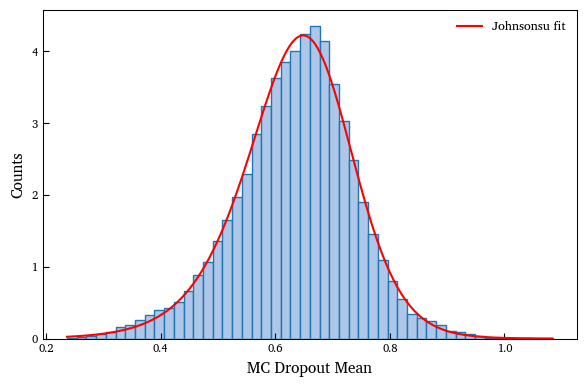

In [51]:
fig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(mcd_mean), max(mcd_mean), 500)

mcd_mean_params = johnsonsu.fit(mcd_mean)
mcd_mean_pdf = johnsonsu.pdf(x, *mcd_mean_params)

_ = plt.hist(mcd_mean, 
             bins=50, 
             density=True,
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])

plt.plot(x, mcd_mean_pdf, 'r-', label='Johnsonsu fit')

plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.legend()
plt.tight_layout()
plt.show()

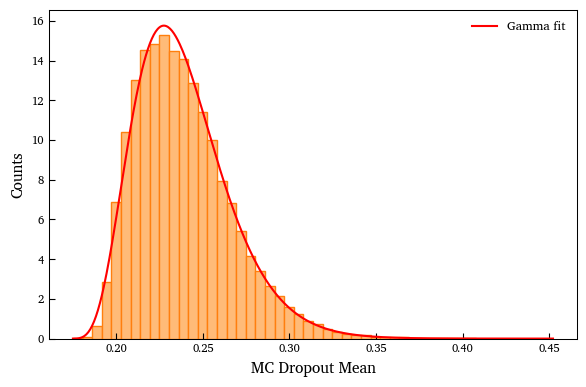

In [52]:
ffig, ax = plt.subplots(figsize=(6,4))

x = np.linspace(min(mcd_std_unbiased), max(mcd_std_unbiased), 500)

mcd_std_params = gamma.fit(mcd_std_unbiased)
mcd_std_pdf = gamma.pdf(x, *mcd_std_params)

_ = plt.hist(mcd_std_unbiased, 
             bins=50, 
             density=True,
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])

plt.plot(x, mcd_std_pdf, 'r-', label='Gamma fit')

plt.xlabel('MC Dropout Mean')
plt.ylabel('Counts')

plt.legend()
plt.tight_layout()
plt.show()

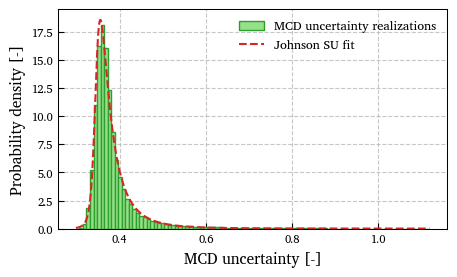

In [64]:
ffig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

x = np.linspace(min(uncertainty), max(uncertainty), 500)

mcd_uncertainty_params = johnsonsu.fit(uncertainty)
mcd_uncertainty_pdf = johnsonsu.pdf(x, *mcd_uncertainty_params)

_ = plt.hist(uncertainty, 
             bins=100, 
             density=True,
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4],
             label='MCD uncertainty realizations',
             zorder=2)

plt.plot(x, mcd_uncertainty_pdf, 
        c=plot_params.colors[3], 
        alpha=1.0,
        linestyle='--',
         label='Johnson SU fit', )

plt.xlabel('MCD uncertainty [-]')
plt.ylabel('Probability density [-]')

plt.grid(True, linestyle='--', alpha=0.7, zorder=0)

plt.legend()
plt.tight_layout()

if plot_params.save_figures:
     plt.savefig(rf'Plots\MC_FittedJohsonSU.svg', format='svg')

plt.show()


$$
f(x) = \frac{\delta}{\sqrt{2\pi} \sqrt{(x - \xi)^2 + \lambda^2}} \exp\left( -\frac{1}{2} \left[ \gamma + \delta \cdot \sinh^{-1}\left( \frac{x - \xi}{\lambda} \right) \right]^2 \right)
$$


𝛾
γ: shape

𝛿
δ: shape

𝜉
ξ: location

𝜆
λ: scale

Estimating the mean and variance from the Johnson SU:

In [65]:
a, b, loc, scale = mcd_uncertainty_params
mu, var = johnsonsu.stats(a, b, loc=loc, scale=scale, moments='mv')
sigma = var**0.5

accepted_error = 0.05
confidence_level = 0.99
z = norm.ppf(1-(1-confidence_level)/2)

n_required = (z * sigma / (accepted_error * mu))**2
print(f"Required sample size for ±{accepted_error*100:.1f}% error at 99% confidence: {int(np.ceil(n_required))}")


Required sample size for ±5.0% error at 99% confidence: 52


Estimating the mean and variance through the Central Limit Theorem:

In [66]:
mu, sigma = mcd_mean.mean(), mcd_std_unbiased.mean()

accepted_error = 0.1
confidence_level = 0.9
z = norm.ppf(1-(1-confidence_level)/2)

n_required = (z * sigma / (accepted_error * mu))**2
print(f"Required sample size for ±{accepted_error*100:.1f}% error at 99% confidence: {int(np.ceil(n_required))}")

Required sample size for ±10.0% error at 99% confidence: 39


### Effect of MC Simulation Number

In [29]:
df_reduced = df_full.sample(10_000).copy()

In [36]:
simulations_tests = [5,10,15,20,50,100,200,500,750,1000]

In [37]:
uncertainty_progression = np.zeros((len(df_reduced), len(simulations_tests)))

for n_simulations in simulations_tests:
    print(n_simulations)
    mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(
        df_input = df_reduced,
        num_samples=n_simulations, 
        dropout_prob=0.1)
    uncertainty = mcd_std_unbiased / mcd_mean

    uncertainty_progression[:, simulations_tests.index(n_simulations)] = uncertainty.flatten()

5
10
15
20
50
100
200
500
750
1000


Progression of uncertainties with increasing sample size:

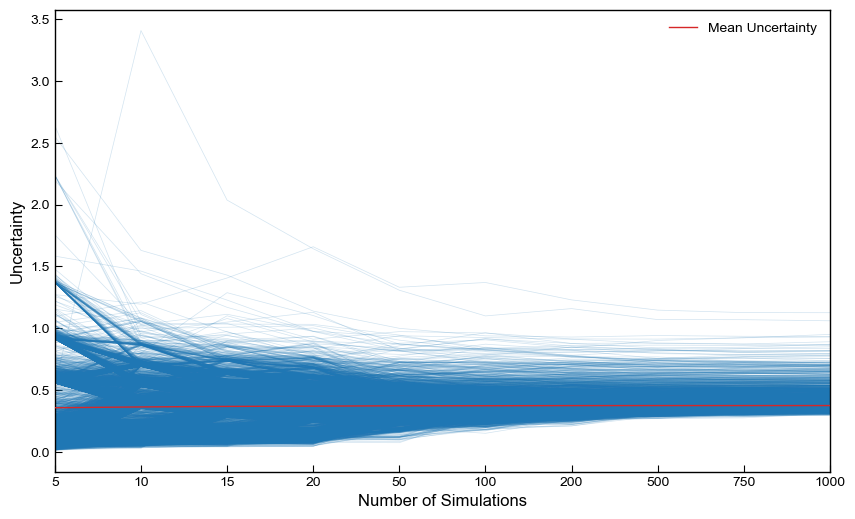

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_reduced)):
    plt.plot(uncertainty_progression[i],
             linewidth=0.5,
             alpha=0.2,
             c=plot_params.colors[0]
    )

plt.plot(np.mean(uncertainty_progression, axis=0),
         linewidth=1,
         c=plot_params.colors[3],
         label="Mean Uncertainty",
         zorder=10
    )

plt.legend()

plt.xlabel("Number of Simulations")
plt.ylabel("Uncertainty")

plt.xticks(range(len(simulations_tests)), simulations_tests)

plt.xlim([0, len(simulations_tests)-1])

plt.show()

Relative progression of uncertainties with increasing sample size.

In [38]:
final_uncertainty = uncertainty_progression[:, -1].reshape(-1, 1)
deviation_from_final = uncertainty_progression / final_uncertainty

accepted_deviation = 0.05

ratio_of_accepted = np.array([
    np.count_nonzero((deviation_from_final[:, i] >= 1 - accepted_deviation) & 
                     (deviation_from_final[:, i] <= 1 + accepted_deviation)) / len(df_reduced)
    for i in range(len(simulations_tests))
])

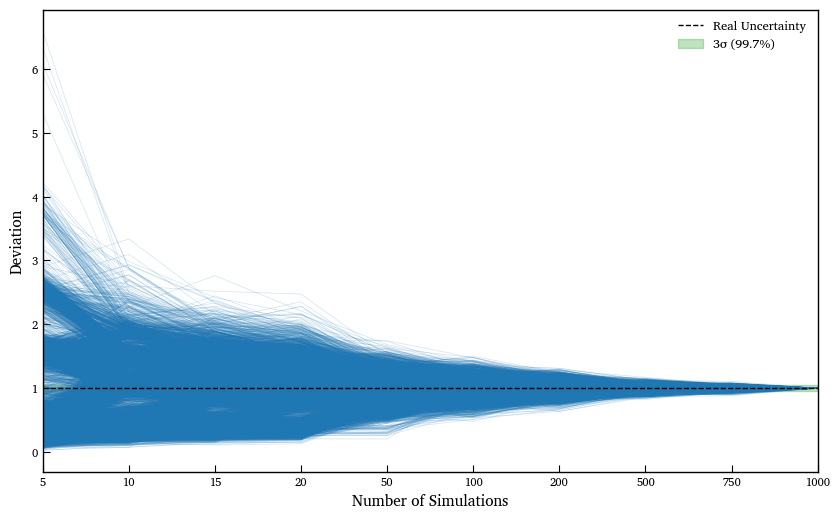

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_reduced)):
    plt.plot(deviation_from_final[i],
             linewidth=0.5,
             alpha=0.2,
             c=plot_params.colors[0]
    )

plt.axhline(y=1, color='k', linestyle='--', linewidth=1, label="Real Uncertainty")

plt.axhspan(1-accepted_deviation, 1+accepted_deviation, 
            alpha=0.3, 
            color=plot_params.colors[2], 
            label='3σ (99.7%)', zorder=0)

plt.legend()

plt.xlabel("Number of Simulations")
plt.ylabel("Deviation")

plt.xticks(range(len(simulations_tests)), simulations_tests)

plt.xlim([0, len(simulations_tests)-1])

plt.show()

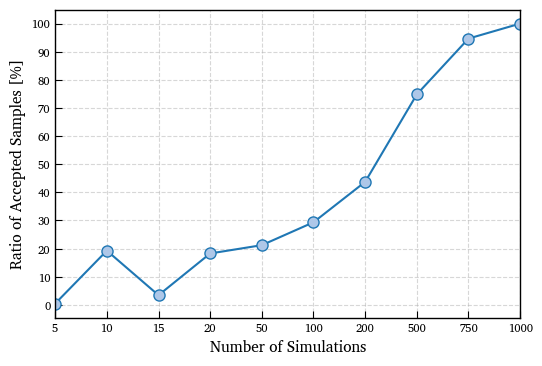

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ratio_of_accepted, 
         marker='o', 
         markersize=8,
         markerfacecolor=plot_params.morecolors[1],
         markeredgecolor=plot_params.morecolors[0], 
         label='Accepted Ratio')

plt.xlabel('Number of Simulations')
plt.ylabel('Ratio of Accepted Samples [%]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, len(simulations_tests)-1)
plt.xticks(range(len(simulations_tests)), simulations_tests)
plt.yticks(np.arange(0, 1.1, 0.1),np.arange(0,101,10))

plt.show()

### Visualize min sample size

In [41]:
mcd_mean, mcd_std_unbiased, mcd_preds = model.mc_dropout_uncertainty(
    df_input = df_reduced,
    num_samples=int(n_required), 
    dropout_prob=0.1)
uncertainty = mcd_std_unbiased / mcd_mean

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


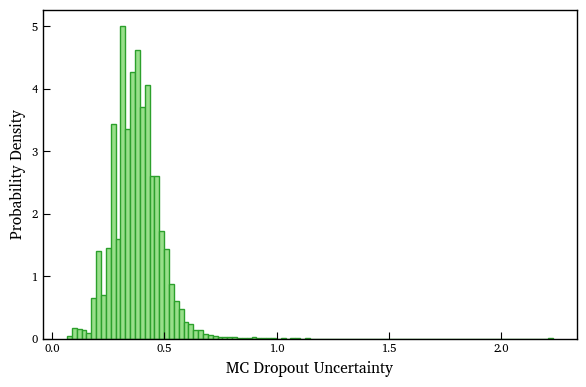

In [42]:
fig, ax = plt.subplots(figsize=(6,4))

#x = np.linspace(min(uncertainty), max(uncertainty), 500)

#mcd_uncertainty_params = johnsonsu.fit(uncertainty)
#mcd_uncertainty_pdf = johnsonsu.pdf(x, *mcd_uncertainty_params)

_ = plt.hist(uncertainty, 
             bins=100, 
             density=True,
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4])

#plt.plot(x, mcd_uncertainty_pdf, 'r-', label='Johnson SU fit')

plt.xlabel('MC Dropout Uncertainty')
plt.ylabel('Probability Density')

plt.legend()
plt.tight_layout()
plt.show()

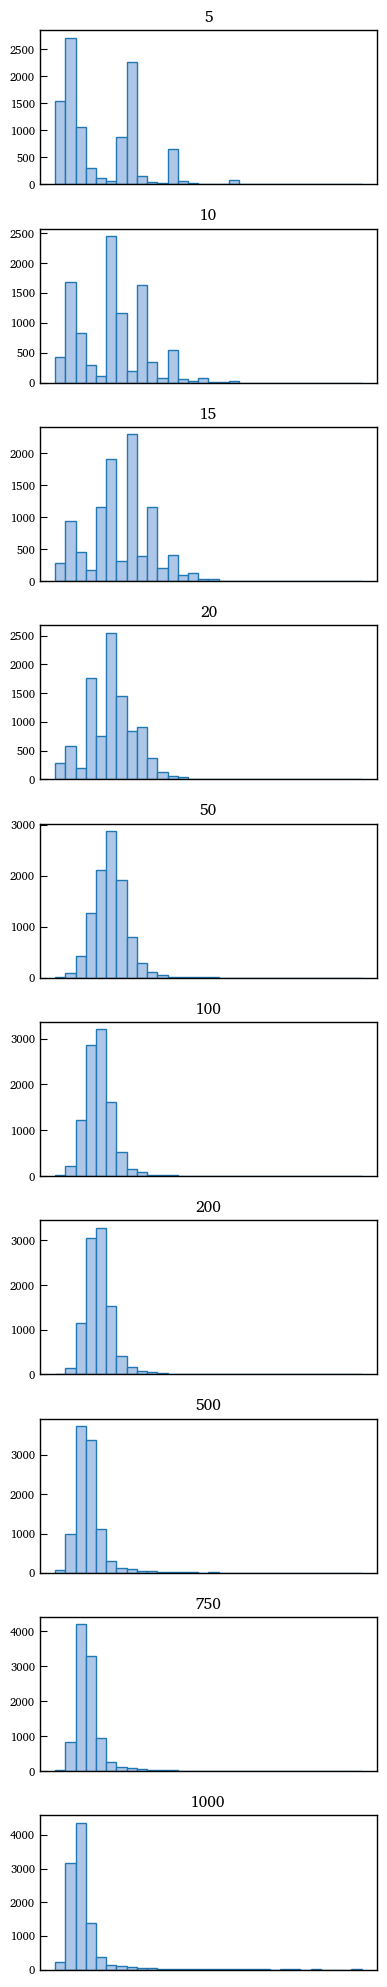

In [43]:
fig, axs = plt.subplots(uncertainty_progression.shape[1],1,figsize=(4,2*uncertainty_progression.shape[1]))

for i in range(uncertainty_progression.shape[1]):
    axs[i].hist(uncertainty_progression[:,i], 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
    axs[i].set_xticks([])
    axs[i].set_title(simulations_tests[i])
    
plt.tight_layout()
plt.show()

In [67]:
top_p_percent = 0.05
top_n_samples = int(len(df_reduced) * top_p_percent)
top_samples = np.zeros((uncertainty_progression.shape[1],top_n_samples))
p_identical = np.zeros(uncertainty_progression.shape[1]-1)
for i,uncertainty in enumerate(uncertainty_progression.T):
    rank = np.argsort(uncertainty)

    top_samples[i] = rank[-top_n_samples:]

for i in range(uncertainty_progression.shape[1]-1):
    p_identical[i] = np.isin(top_samples[i], top_samples[-1]).sum() / top_n_samples

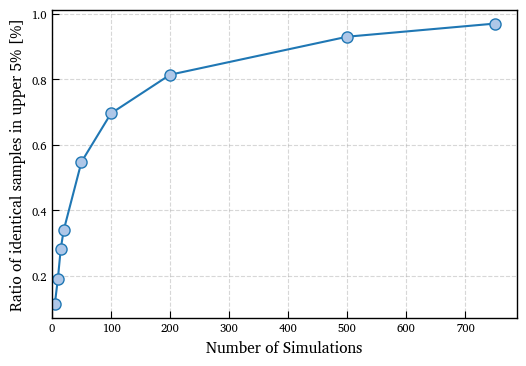

In [75]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(simulations_tests[:-1],p_identical,
         color=plot_params.colors[0],
         marker='o',
         markerfacecolor=plot_params.morecolors[1],
         markeredgecolor=plot_params.morecolors[0],
         markersize=8,
         label='Identical Samples Ratio')

plt.xlabel('Number of Simulations')
plt.ylabel('Ratio of identical samples in upper 5% [%]')
plt.xlim(0,None)

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [27]:
def estimate_required_samples(model, df_input, accepted_deviation=0.05, target_ratio=0.99, final_samples=2000, max_samples=1000, step=10):
    print("Computing reference uncertainty with", final_samples, "samples...")
    mcd_mean_ref, mcd_std_ref, _ = model.mc_dropout_uncertainty(
        df_input=df_input,
        num_samples=final_samples,
        dropout_prob=0.1
    )
    uncertainty_ref = mcd_std_ref / mcd_mean_ref

    sample_sizes = list(range(step, max_samples + 1, step))
    for n in sample_sizes:
        mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(
            df_input=df_input,
            num_samples=n,
            dropout_prob=0.1
        )
        uncertainty_est = mcd_std / mcd_mean
        deviation = np.abs(uncertainty_est / uncertainty_ref - 1)

        ratio_within_error = np.mean(deviation <= accepted_deviation)

        print(f"Samples: {n}, Ratio within ±{accepted_deviation*100:.0f}%: {ratio_within_error:.3f}")

        if ratio_within_error >= target_ratio:
            print(f"\n✅ Minimum required samples: {n} (Ratio: {ratio_within_error:.3f})")
            return n

    print("\n❌ Did not reach target accuracy within max_samples")
    return None


In [31]:
estimate_required_samples(model, df_reduced, accepted_deviation=0.1, target_ratio=0.90, final_samples=3000, max_samples=2000, step=100)

Computing reference uncertainty with 3000 samples...
Samples: 100, Ratio within ±10%: 0.536
Samples: 200, Ratio within ±10%: 0.704
Samples: 300, Ratio within ±10%: 0.809
Samples: 400, Ratio within ±10%: 0.875
Samples: 500, Ratio within ±10%: 0.919

✅ Minimum required samples: 500 (Ratio: 0.919)


500